In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from pathlib import Path
import numpy as np
import copy

In [3]:
dir_github = Path(r'/media/rich/Home_Linux_partition/github_repos/').resolve()

dir_analysisFiles = Path(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/BMI_IDAP_run').resolve()

## Directory with F.npy, stat.npy etc.
dir_s2p = Path(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/suite2p/plane0').resolve()



## Path of iscell. Can be from neural net output (iscell_NN)
path_iscell = dir_analysisFiles / 'iscell_NN_tqm.npy'

## Path of tqm (trace quality metrics). Used to get dFoF parameters
path_tqm = dir_analysisFiles / 'trace_quality.pkl'


## Directory of the Cascade repo
dir_cascade = dir_github / 'Cascade'

## Directory to save spks_cas into
dir_save = dir_analysisFiles

In [8]:
import sys
# sys.path.append('/n/groups/datta/akshay/bmi')
sys.path.append(str(dir_github))

# from Cascade import cascade2p.cascade2p
from cascade2p import checks
checks.check_packages()
from cascade2p import cascade # local folder
from cascade2p.utils import plot_dFF_traces, plot_noise_level_distribution, plot_noise_matched_ground_truth

# my libraries
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import *

	YAML reader installed (version 0.17.21).
	Keras installed (version 2.4.0).
	Tensorflow installed (version 2.4.1).
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
## == IMPORT DATA ==
F = np.load(dir_s2p / 'F.npy') # masks multiplied by data
Fneu = np.load(dir_s2p / 'Fneu.npy') # estimated neuropil signal (Fns = F - Fneu; Fo = ptile(Fns, 30); dFoF=Fns-Fo/Fo)
# iscell = np.load(dir_s2p/'iscell.npy') # probability and bool of each roi
ops = np.load(dir_s2p / 'ops.npy', allow_pickle=True) # parameters for the suite2p
spks_s2p = np.load(dir_s2p / 'spks.npy') # blind deconvolution
stat = np.load(dir_s2p / 'stat.npy', allow_pickle=True) # statistics for individual neurons 

num_frames_S2p = F.shape[1]
Fs = ops[()]['fs']

In [10]:
iscell = np.load(path_iscell)
dFoF_params = pickle_helpers.simple_load(path_tqm)['dFoF_params']

In [11]:
F_toUse = F[iscell]
Fneu_toUse = Fneu[iscell]

Calculated dFoF. Total elapsed time: 9.38 seconds
ThreadPool elapsed time : 0.41 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 0.64 seconds


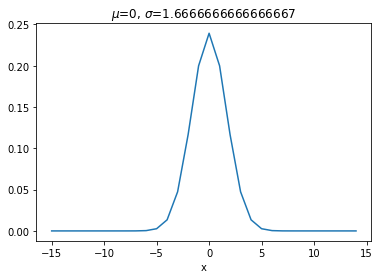

In [16]:
channelOffset_correction = dFoF_params['channelOffset_correction']
percentile_baseline      = dFoF_params['percentile_baseline']
neuropil_fraction        = dFoF_params['neuropil_fraction']

dFoF , dF , F_neuSub , F_baseline = ca2p_preprocessing.make_dFoF(F=F_toUse + channelOffset_correction,
                                                                 Fneu=Fneu_toUse + channelOffset_correction,
                                                                 neuropil_fraction=neuropil_fraction,
                                                                 percentile_baseline=percentile_baseline,
                                                                 multicore_pref=True,
                                                                 verbose=True)

kernel_smoothing = math_functions.gaussian(np.arange(-(Fs)//2, (Fs)//2), 0, sig=50/Fs, plot_pref=True)[0]
dFoF_smooth = timeSeries.convolve_along_axis(dFoF,
                                             kernel=kernel_smoothing,
                                             axis=1,mode='same',
                                             multicore_pref=True,
                                             verbose=True).astype(np.float32)

In [12]:
## Allow for downloading through SSL
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [13]:
def show_available_models(dir_cascade):
#     import ssl
#     ssl._create_default_https_context = ssl._create_unverified_context

    cascade.download_model('update_models', model_folder=dir_cascade, verbose = 1)

    yaml_file = open(dir_cascade / 'Pretrained_models/available_models.yaml')
    # yaml_file = open('Pretrained_models/available_models.yaml')
    X = yaml.load(yaml_file, Loader=yaml.Loader)
    list_of_models = list(X.keys())
    print('\n List of available models: \n')
    for model in list_of_models:
        print(model)

def download_model(model_name='Global_EXC_30Hz_smoothing50ms_causalkernel', dir_cascade='/', verbose=True):
    cascade.download_model( model_name, model_folder=dir_cascade, verbose = 1)

def predict(traces, dir_cascade='/', num_batches=1, empty_list_for_inplace_dataRecovery=[]):
    from tqdm import tqdm
    spike_probs = empty_list_for_inplace_dataRecovery
    with tqdm(total=num_batches) as pbar:
        for batch in indexing.make_batches(traces, num_batches=num_batches):
            spike_prob = cascade.predict(model_name=model_name,
                                                     traces=batch, 
                                                     model_folder=dir_cascade, 
                                                     padding=0)
            spike_probs.append(spike_prob)
            pbar.update(1)

    spks_cas = np.concatenate(spike_probs, axis=0).astype(np.float32)
    return spks_cas

In [14]:
model_name = 'Global_EXC_30Hz_smoothing50ms_causalkernel'

download_model( model_name, dir_cascade=dir_cascade, verbose=True)

Pretrained model was saved in folder "/media/rich/Home_Linux_partition/github_repos/Cascade/Global_EXC_30Hz_smoothing50ms_causalkernel"


In [15]:
import tensorflow as tf
tf.config.list_physical_devices()

2022-02-19 16:12:22.389013: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-19 16:12:22.389162: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-19 16:12:22.451597: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.67GiB deviceMemoryBandwidth: 871.81GiB/s
2022-02-19 16:12:22.451647: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-02-19 16:12:22.456209: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-02-19 16:12:22.456292: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

fft.so.10
2022-02-19 16:12:22.457493: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2022-02-19 16:12:22.469359: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusolver.so.10
2022-02-19 16:12:22.469943: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusparse.so.11
2022-02-19 16:12:22.470121: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-02-19 16:12:22.471148: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1862] Adding visible gpu devices: 0


In [17]:
traces_toUse = dFoF_smooth
batch_size = 100

num_batches = np.ceil(traces_toUse.shape[0]/batch_size).astype(np.int64)
fallback = []
spks_cas = predict(
    traces=traces_toUse,
    dir_cascade=dir_cascade,
    num_batches=num_batches,
    empty_list_for_inplace_dataRecovery=fallback
)

  0%|                                                    | 0/12 [00:00<?, ?it/s]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 100 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.25, 0.06

Predictions for noise level 2:


2022-02-19 16:12:49.044474: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-19 16:12:49.045325: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-19 16:12:49.046207: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.67GiB deviceMemoryBandwidth: 871.81GiB/s
2022-02-19 16:12:49.046249: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-02-19 16:12:49.046312: I tensorflow/stream_executor/platform/default/dso_

	... ensemble 0


2022-02-19 16:12:53.705310: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-19 16:12:53.721862: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz
2022-02-19 16:12:53.881952: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-02-19 16:12:54.634145: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-02-19 16:12:54.636340: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-02-19 16:12:57.630781: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for op

2022-02-19 16:13:02.118469: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-19 16:13:02.309921: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-19 16:13:02.495159: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-19 16:13:02.688348: W tensorflow/stream_executor/gpu/

  39/1319 [..............................] - ETA: 5s 

2022-02-19 16:13:06.714835: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-19 16:13:06.717080: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1315/1319 [============================>.] - ETA: 0s

2022-02-19 16:13:11.919580: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-19 16:13:12.121154: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-19 16:13:12.322929: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-19 16:13:12.526929: W tensorflow/stream_executor/gpu/

2022-02-19 16:13:17.358901: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-19 16:13:17.558155: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-19 16:13:17.762082: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-19 16:13:17.985818: W tensorflow/stream_executor/gpu/

1319/1319 [==============================] - 29s 12ms/step


2022-02-19 16:13:23.051320: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



	... ensemble 1
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 2
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 3
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 4
1319/1319 [==============================] - 5s 4ms/step


  8%|███▋                                        | 1/12 [01:12<13:16, 72.43s/it]


Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for noise level 6:
	No neurons for this noise level

Predictions for noise level 7:
	No neurons for this noise level

Predictions for noise level 8:
	No neurons for this noise level
Done

 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 100 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.26, 0.05

Predictions for noise level 2:
	... ensemble 0
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 1
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 2
1319/1319 [===

 17%|███████▎                                    | 2/12 [02:00<09:40, 58.08s/it]


Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for noise level 6:
	No neurons for this noise level

Predictions for noise level 7:
	No neurons for this noise level

Predictions for noise level 8:
	No neurons for this noise level
Done

 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 100 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.25, 0.06

Predictions for noise level 2:
	... ensemble 0
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 1
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 2
1319/1319 [===

 25%|███████████                                 | 3/12 [02:48<08:00, 53.41s/it]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 100 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.26, 0.06

Predictions for noise level 2:
	... ensemble 0
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 1
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 2
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 3
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 4
1319/1319 [==============================] - 5s 4ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Prediction

 33%|██████████████▋                             | 4/12 [03:36<06:49, 51.24s/it]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 100 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.26, 0.06

Predictions for noise level 2:
	... ensemble 0
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 1
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 2
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 3
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 4
1319/1319 [==============================] - 5s 4ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Prediction

 42%|██████████████████▎                         | 5/12 [04:24<05:50, 50.11s/it]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 100 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.26, 0.06

Predictions for noise level 2:
	... ensemble 0
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 1
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 2
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 3
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 4
1319/1319 [==============================] - 5s 4ms/step


 50%|██████████████████████                      | 6/12 [05:13<04:58, 49.72s/it]


Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for noise level 6:
	No neurons for this noise level

Predictions for noise level 7:
	No neurons for this noise level

Predictions for noise level 8:
	No neurons for this noise level
Done

 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 100 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.24, 0.06

Predictions for noise level 2:
	... ensemble 0
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 1
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 2
1319/1319 [===

 58%|█████████████████████████▋                  | 7/12 [06:01<04:05, 49.14s/it]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 100 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.25, 0.06

Predictions for noise level 2:
	... ensemble 0
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 1
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 2
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 3
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 4
1319/1319 [==============================] - 5s 4ms/step


 67%|█████████████████████████████▎              | 8/12 [06:49<03:15, 48.84s/it]


Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for noise level 6:
	No neurons for this noise level

Predictions for noise level 7:
	No neurons for this noise level

Predictions for noise level 8:
	No neurons for this noise level
Done

 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 100 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.25, 0.07

Predictions for noise level 2:
	... ensemble 0
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 1
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 2
1319/1319 [===

 75%|█████████████████████████████████           | 9/12 [07:37<02:25, 48.50s/it]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 100 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.25, 0.06

Predictions for noise level 2:
	... ensemble 0
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 1
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 2
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 3
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 4
1319/1319 [==============================] - 5s 4ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Prediction

 83%|███████████████████████████████████▊       | 10/12 [08:25<01:36, 48.31s/it]

Done

 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 100 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.25, 0.06

Predictions for noise level 2:
	... ensemble 0
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 1
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 2
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 3
1319/1319 [==============================] - 5s 4ms/step
	... ensemble 4
1319/1319 [==============================] - 5s 4ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predi

 92%|███████████████████████████████████████▍   | 11/12 [09:13<00:48, 48.21s/it]

Done

 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 99 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.24, 0.06

Predictions for noise level 2:
	... ensemble 0
1294/1306 [============================>.] - ETA: 0s

2022-02-19 16:22:12.320708: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-19 16:22:13.098004: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-19 16:22:13.877891: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-19 16:22:14.665358: W tensorflow/stream_executor/gpu/

2022-02-19 16:22:33.530190: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-19 16:22:34.322338: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-19 16:22:35.102192: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-19 16:22:35.899249: W tensorflow/stream_executor/gpu/

2022-02-19 16:22:54.804686: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



1306/1306 [==============================] - 49s 38ms/step


2022-02-19 16:22:55.593001: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



	... ensemble 1
1306/1306 [==============================] - 5s 4ms/step
	... ensemble 2
1306/1306 [==============================] - 5s 4ms/step
	... ensemble 3
1306/1306 [==============================] - 5s 4ms/step
	... ensemble 4
1306/1306 [==============================] - 5s 4ms/step


100%|███████████████████████████████████████████| 12/12 [10:44<00:00, 53.72s/it]


Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for noise level 6:
	No neurons for this noise level

Predictions for noise level 7:
	No neurons for this noise level

Predictions for noise level 8:
	No neurons for this noise level
Done


In [19]:
np.save(dir_save / 'spks_cas.npy', np.single(spks_cas))

In [20]:
pickle_helpers.save_dict(
    obj={
        "iscell_spksCas": iscell,
        "dFoF_params": dFoF_params,
        "model_name": model_name,
    },
    filename= dir_save / 'spksCas_params.pkl'
)